# In this notebook, we perform an example optimization of a quasi-helical configuration. Here the field strength is expressed in terms of the Fourier harmonics with respect to the Boozer angles $(\vartheta_B,\varphi_B)$,

# $ B(\psi,\vartheta_B,\varphi_B) = \sum_{m,n} B_{m,n}(\psi) \cos(m\vartheta_B - n \varphi_B)$

# by minimizing the non-symmetric Boozer harmonics,

# $ f(\psi) = \sum_{M n \ne m N} \frac{B_{m,n}(\psi)^2}{B_{0,0}(\psi)^2}$,

# with respect to the shape of the boundary of the MHD equilibrium.

# First, we import modules

In [1]:
from time import time
from simsopt.mhd import Vmec, Boozer, Quasisymmetry
from simsopt.objectives.graph_least_squares import LeastSquaresProblem
from simsopt.solve.graph_serial import least_squares_serial_solve
import os
import numpy as np

import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

import matplotlib.pyplot as plt

# We now initialize the equilibrium and Boozer coordinate transformation

# Here the MHD equilibrium in the volume, $\mathcal{V}$, is computed given the shape of the initial boundary, $\mathcal{S}$,

# $\textbf{J} \times \textbf{B} = \nabla p \hspace{1cm} \textbf{in }\mathcal{V}$

# $\nabla \cdot \textbf{B} = 0 \hspace{1cm} \textbf{in }\mathcal{V}$

# $ \textbf{B} \cdot \hat{\textbf{n}} = 0 \hspace{1cm} \textbf{on }\mathcal{S}$.

In [2]:
vmec = Vmec('input.nfp4_QH_warm_start')
# Configure quasisymmetry objective:
qs = Quasisymmetry(Boozer(vmec),
                   0.5,  # Radius to target
                   1, 1)  # (M, N) you want in |B|
booz = qs.boozer

# We perform the Boozer coordinate transformation for this initial equilibrium

In [3]:
booz.run()

mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128


# We now process the output of the Boozer coordinate transformation and equilibrium. 

In [4]:
nfp = booz.bx.nfp
ntheta = 100 # number of poloidal grid points
nphi = 400 # number of toroidal grid points

# Initialize grids
thetas = np.linspace(0,2*np.pi,ntheta)
phis = np.linspace(0,2*np.pi,nphi)
thetas, phis = np.meshgrid(thetas,phis)

# Inverse FT the surface and magnetic field magnitude
bmnc_b = booz.bx.bmnc_b
bmnc_v = vmec.wout.bmnc
rmnc_v = vmec.wout.rmnc
zmns_v = vmec.wout.zmns
xm_v_nyq = vmec.wout.xm_nyq
xn_v_nyq = vmec.wout.xn_nyq
xm_v = vmec.wout.xm
xn_v = vmec.wout.xn
xm_b = booz.bx.xm_b
xn_b = booz.bx.xn_b
phi = vmec.wout.phi
s = phi/phi[-1]
ds = s[1]
s_half = s[1:] - 0.5 * ds

index = np.argmin(np.abs(s_half - 0.5))

bmnc_v = bmnc_v[:,index]
rmnc_v = (rmnc_v[:,index] + rmnc_v[:,index-1])/2
zmns_v = (zmns_v[:,index] + zmns_v[:,index-1])/2

B_b = np.zeros_like(thetas)
for im in range(len(xm_b)):
    angle = xm_b[im] * thetas - xn_b[im] * phis
    B_b += bmnc_b[im] * np.cos(angle)
B_v = np.zeros_like(thetas)
for im in range(len(xm_v_nyq)):
    angle = xm_v_nyq[im] * thetas - xn_v_nyq[im] * phis
    B_v += bmnc_v[im] * np.cos(angle)
R = np.zeros_like(thetas)
Z = np.zeros_like(thetas)
for im in range(len(xm_v)):
    angle = xm_v[im] * thetas - xn_v[im] * phis
    R += rmnc_v[im] * np.cos(angle)
    Z += zmns_v[im] * np.sin(angle)
X = R * np.cos(phis)
Y = R * np.sin(phis)

# Plot field strength in Boozer coordinates

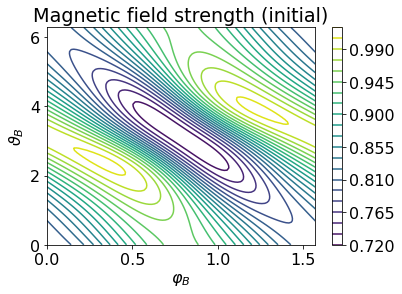

In [5]:
plt.figure()
plt.contour(phis,thetas,B_b,20)
plt.xlim([0,2*np.pi/nfp])
plt.xlabel(r'$\varphi_B$')
plt.ylabel(r'$\vartheta_B$')
plt.title('Magnetic field strength (initial)')
plt.colorbar()
plt.show()

# Plot cross-sections of initial plasma boundary

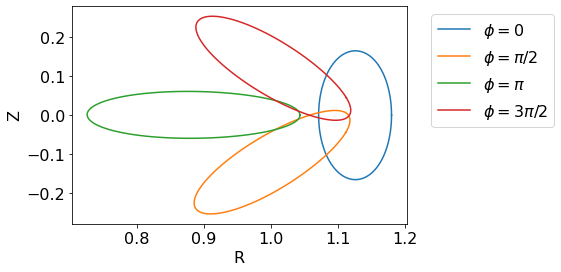

In [6]:
plt.figure()
plt.plot(R[0,:],Z[0,:])
plt.plot(R[25,:],Z[25,:])
plt.plot(R[50,:],Z[50,:])
plt.plot(R[75,:],Z[75,:])
plt.xlabel('R')
plt.ylabel('Z')
plt.legend([r'$\phi = 0$',r'$\phi = \pi/2$',r'$\phi=\pi$',r'$\phi=3\pi/2$'],bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot field strength on boundary

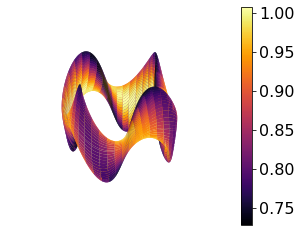

In [7]:
scamap = plt.cm.ScalarMappable(cmap='inferno')
fcolors = scamap.to_rgba(B_v)

gamma = vmec.boundary.gamma()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax._axis3don = False
surf = ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='inferno',linewidth=0)
fig.colorbar(scamap)

# Optimize for quasi-helical symmetry $(M=1, N=1)$ on this surface. For brevity, we just run 10 function evaluations. (modify max_nfev to increase this)

# Here the boundary of the plasma is defined by,

# $R(\theta,\phi) = \sum_{m,n} R_{m,n} \cos(m \theta - n \phi)$

# $Z(\theta,\phi) = \sum_{m,n} Z_{m,n} \sin(m \theta - n \phi)$,

# where $\phi$ is the cylindrical toroidal angle and $\theta$ is a parameterization poloidal angle. We take $\{R_{m,n},Z_{m,n}\}$ to be our optimization parameters.

# In this example, we only optimize over the harmonics with $|n|, m\le 2$, to minimize the non-symmetric Boozer harmonics on the $\psi = \psi_0/2$ surface, where $\psi_0$ is the toroidal flux of the outer boundary. We also fix the $R_{0,0}$ parameter to fix one length scale of the equilibrium.

# This will take about 15 minutes 

In [8]:
# Define parameter space:
surf = vmec.boundary
surf.fix_all()
max_mode = 2
surf.fixed_range(mmin=0, mmax=max_mode, nmin=-max_mode, nmax=max_mode, fixed=False)
surf.fix("rc(0,0)")  # Major radius

# Define objective function as a least-squares problem
prob = LeastSquaresProblem.from_tuples([(vmec.aspect, 7, 1),(qs.J, 0, 1)])

time1 = time()
least_squares_serial_solve(prob, grad=True, max_nfev=10,rel_step=1e-3, abs_step=1e-5)
time2 = time()
print('Time for optimization: ',time2-time1,' seconds.')

prob is  LeastSquaresProblem1
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  le

Function evaluation failed for <bound method Vmec.aspect of Vmec1 (nfp=4 mpol=5 ntor=5)>


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.0956e-04                                    4.38e-02    
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50

mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_nyq: 128  len(xm_nyq): 128  len(xn_nyq): 128
mnmax: 50  len(xm): 50  len(xn): 50
mnmax_n

# Process output of optimized equilibrium

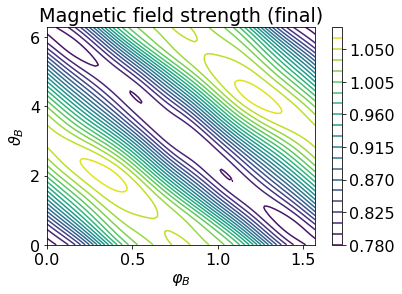

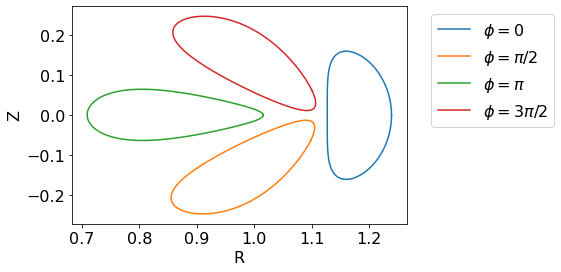

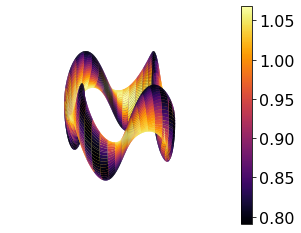

In [9]:
bmnc_b = booz.bx.bmnc_b
bmnc_v = vmec.wout.bmnc
rmnc_v = vmec.wout.rmnc
zmns_v = vmec.wout.zmns

bmnc_v = bmnc_v[:,index]
rmnc_v = (rmnc_v[:,index] + rmnc_v[:,index-1])/2
zmns_v = (zmns_v[:,index] + zmns_v[:,index-1])/2

B_b = np.zeros_like(thetas)
for im in range(len(xm_b)):
    angle = xm_b[im] * thetas - xn_b[im] * phis
    B_b += bmnc_b[im] * np.cos(angle)
B_v = np.zeros_like(thetas)
for im in range(len(xm_v_nyq)):
    angle = xm_v_nyq[im] * thetas - xn_v_nyq[im] * phis
    B_v += bmnc_v[im] * np.cos(angle)
R = np.zeros_like(thetas)
Z = np.zeros_like(thetas)
for im in range(len(xm_v)):
    angle = xm_v[im] * thetas - xn_v[im] * phis
    R += rmnc_v[im] * np.cos(angle)
    Z += zmns_v[im] * np.sin(angle)
X = R * np.cos(phis)
Y = R * np.sin(phis)

import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

plt.contour(phis,thetas,B_b,20)
plt.xlim([0,2*np.pi/nfp])
plt.xlabel(r'$\varphi_B$')
plt.ylabel(r'$\vartheta_B$')
plt.title('Magnetic field strength (final)')
plt.colorbar()

plt.figure()
plt.plot(R[0,:],Z[0,:])
plt.plot(R[25,:],Z[25,:])
plt.plot(R[50,:],Z[50,:])
plt.plot(R[75,:],Z[75,:])
plt.xlabel('R')
plt.ylabel('Z')
plt.legend([r'$\phi = 0$',r'$\phi = \pi/2$',r'$\phi=\pi$',r'$\phi=3\pi/2$'],bbox_to_anchor=(1.05, 1), loc='upper left')

scamap = plt.cm.ScalarMappable(cmap='inferno')
fcolors = scamap.to_rgba(B_v)

gamma = vmec.boundary.gamma()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax._axis3don = False
surf = ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='inferno',linewidth=0)
fig.colorbar(scamap)